# Network Analysis on Auckland road data
### Import packages

In [1]:
import numpy as np
import pandas as pd
import osmnx as ox
import geopandas as gpd
from shapely.geometry import MultiPolygon, Point
from shapely.ops import transform
import pyproj
import networkx as nx
import math
import matplotlib.pyplot as plt
from pyproj import CRS
import itertools
import networkx as nx

### Importing the road network

In [2]:
auck_network = ox.io.load_graphml("data/network_analysis/auckland_network_walk_unconsolidated.graphml")

# Adding other data
### Import the grid of urban Auckland including census variables
The IDW was done in R. Code in the file data-prep.R

In [3]:
grid = gpd.read_file("data/geographic/grids/grid_50000_auckland_allDist.gpkg")
grid['lon'] = grid['geometry'].x
grid['lat'] = grid['geometry'].y
grid.head()

,income,no_households,maori_pr,dampness,lon,lat,ne_u,ne_v,ne_dist,Count_NUMPOINTS,geometry
0,36710.691419,50.796403,0.201352,127.790087,225532.509406,609808.736016,9872095432,7543967816,0,0.0,POINT (225532.509 609808.736)
1,36882.949283,50.309440,0.198384,126.097575,225657.352287,609808.736016,9872095432,7543967816,0,0.0,POINT (225657.352 609808.736)
2,37549.885003,48.335262,0.197472,124.746673,225782.195169,609808.736016,9872095432,7543967816,0,0.0,POINT (225782.195 609808.736)
3,38054.679447,47.356256,0.189796,117.682066,225907.038050,609808.736016,9872095432,7543967816,0,0.0,POINT (225907.038 609808.736)
4,38253.993943,47.114833,0.185706,115.530078,226031.880931,609808.736016,9872095432,7543967816,0,0.0,POINT (226031.881 609808.736)


### Import the train stations in Auckland
The IDW was done in R. Code in the file data-prep.R

<AxesSubplot: >

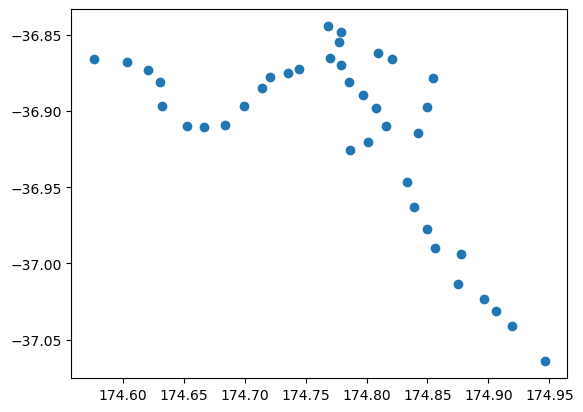

In [4]:
stations = gpd.read_file("data/transport/public_transport/trains_auckland_with_distances_on_network.gpkg")
stations['lon'] = stations['geometry'].x
stations['lat'] = stations['geometry'].y
stations.plot()

### Calculate distances for each point


In [6]:
nodes_proj, edges_proj = ox.graph_to_gdfs(auck_network, nodes=True, edges=True)

In [10]:
stations = stations.to_crs(grid.crs)

<AxesSubplot: >

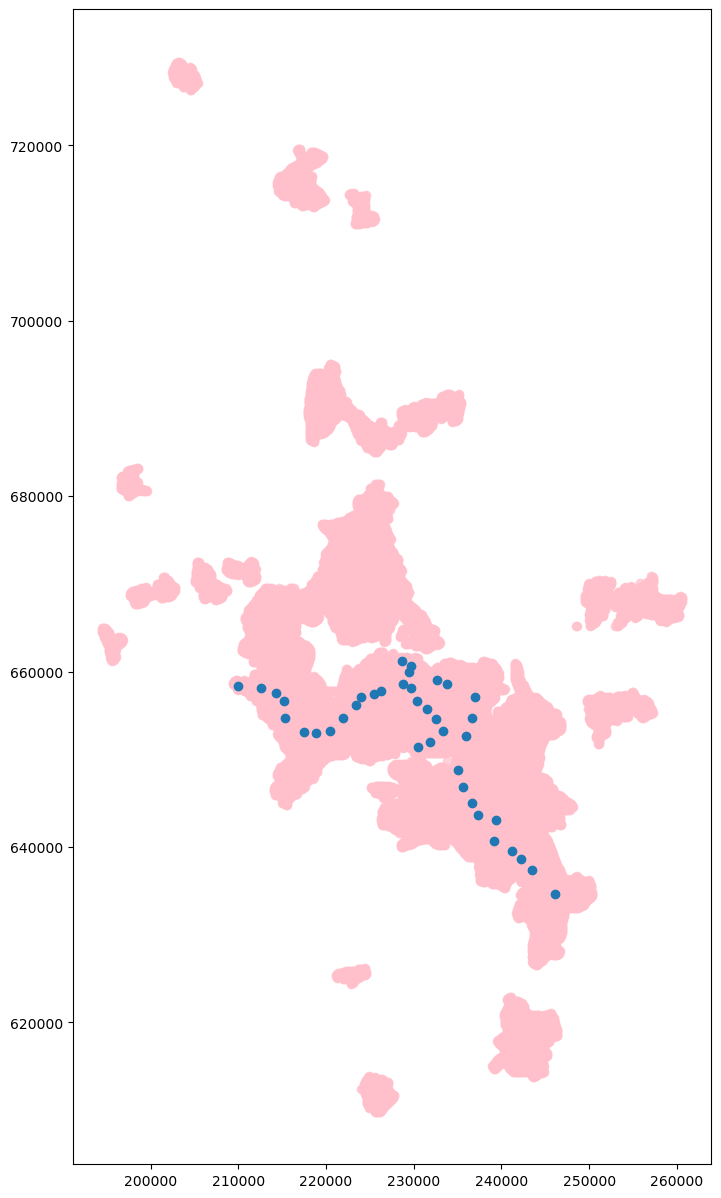

In [11]:
fig, ax = plt.subplots(figsize=(15, 15))
grid.plot(ax=ax, alpha=0.7, color="pink")
stations.plot(ax=ax)

In [12]:
for pidx, point in enumerate(grid.itertuples()):
    orig_node, dist_origin_to_edge = ox.distance.nearest_nodes(auck_network, point.geometry.x, point.geometry.y, return_dist=True) 
    o_closest = nodes_proj.loc[orig_node]
    
    for sidx, station in enumerate(stations.itertuples()):
        target_node, dist_target_to_edge = ox.distance.nearest_nodes(auck_network, station.lon, station.lat, return_dist=True)
        t_closest = nodes_proj.loc[target_node]
        #od_nodes = gpd.GeoDataFrame([o_closest, t_closest], geometry='geometry', crs=nodes_proj.crs)
        shortest_path_length = nx.shortest_path_length(auck_network, source=orig_node, target=target_node, weight='length')
        shortest_path_full_length = shortest_path_length + dist_origin_to_edge + dist_target_to_edge
        
        dict_station_dist = {}
        keys=[]
        values=[]
        keys.append(station.STOPNAME)
        values.append(shortest_path_full_length)

        for key, value in zip(keys, values):
            dict_station_dist[key] = value

        closest_station = min(dict_station_dist, key=dict_station_dist.get) #min alphabetically max(stats, key=stats.get)
        minimum_distance = min(dict_station_dist.values())
    print("Doing point", pidx, ". Distance to nearest station: ", closest_station, " is ", minimum_distance)

    #grid2.loc[pidx].shortest_distance_to_station = minimum_dist    

KeyboardInterrupt: 